# Day 6 - Dinâmica de Faturamento

## Preparação

### Instalando Bibliotecas

In [13]:
!pip install --user -r requirements.txt

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import scipy.stats as st
import sweetviz as sv
import seaborn as sns
import statistics  as sts
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from tpot import TPOTClassifier
from yellowbrick.model_selection import FeatureImportances
import chardet
from datetime import datetime
from datetime import date
import os
import random

ERROR: Could not find a version that satisfies the requirement skopt
ERROR: No matching distribution found for skopt
C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### Lendo Dados

In [14]:
df_features = pd.read_csv('Dados/features.csv')
df_stores = pd.read_csv('Dados/stores.csv')
df_train = pd.read_csv('Dados/train.csv')

In [15]:
df_features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [16]:
df_stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [17]:
df_train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


### Mesclando Dados

In [18]:
df_features = df_features.merge(df_stores, on=['Store'], how='left')
df = df_features.merge(df_train, on=['Store', 'Date'], how='left')
df 

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Type,Size,Dept,Weekly_Sales,IsHoliday_y
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1.0,24924.50,False
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,2.0,50605.27,False
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,3.0,13740.12,False
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,4.0,39954.04,False
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5.0,32229.38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423320,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221,NaN,NaN,NaN
423321,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221,NaN,NaN,NaN
423322,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221,NaN,NaN,NaN
423323,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221,NaN,NaN,NaN


### Explorando Dados

In [19]:
df_features.shape

(8190, 14)

In [20]:
(df_features.isnull().sum()/df_features.shape[0])*100

Store            0.000000
Date             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.769231
MarkDown2       64.334554
MarkDown3       55.885226
MarkDown4       57.704518
MarkDown5       50.549451
CPI              7.142857
Unemployment     7.142857
IsHoliday        0.000000
Type             0.000000
Size             0.000000
dtype: float64

In [21]:
df_features[df_features['Unemployment'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False,A,151315
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False,A,151315
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False,A,151315
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False,A,151315
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221


In [22]:
df = df.drop(columns=['IsHoliday_y'])

In [23]:
df.head(1)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,1.0,24924.5


In [24]:
df['MarkDown1'] = df['MarkDown1'].fillna(0)
df['MarkDown2'] = df['MarkDown2'].fillna(0)
df['MarkDown3'] = df['MarkDown3'].fillna(0)
df['MarkDown4'] = df['MarkDown4'].fillna(0)
df['MarkDown5'] = df['MarkDown5'].fillna(0)

In [25]:
df.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1          0
MarkDown2          0
MarkDown3          0
MarkDown4          0
MarkDown5          0
CPI              585
Unemployment     585
IsHoliday_x        0
Type               0
Size               0
Dept            1755
Weekly_Sales    1755
dtype: int64

In [26]:
df.describe(percentiles=[0.99])

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Dept,Weekly_Sales
count,423325.000000,423325.000000,423325.000000,423325.000000,423325.000000,423325.000000,423325.000000,423325.000000,422740.000000,422740.000000,423325.000000,421570.000000,421570.000000
mean,22.203860,60.067140,3.361933,2609.393788,887.229665,474.645154,1090.251506,1671.367162,171.218863,7.957296,136701.215794,44.260317,15981.258123
std,12.786244,18.452599,0.458038,6084.868435,5096.047794,5578.580578,3914.158379,4370.213498,39.167088,1.863433,60990.977801,30.492054,22711.183519
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,126.064000,3.684000,34875.000000,1.000000,-4988.940000
50%,22.000000,62.070000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000,37.000000,7612.030000
99%,45.000000,92.810000,4.202000,28177.290000,21909.930000,2100.010000,16864.330000,15590.530000,225.478263,14.180000,219622.000000,98.000000,106479.586000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000,99.000000,693099.360000


In [27]:
df['Date'] = pd.to_datetime(df['Date'])

In [28]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day

In [29]:
df.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Type,Size,Dept,Weekly_Sales,year,month,day
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,1.0,24924.50,2010,2,5
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,2.0,50605.27,2010,2,5


<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

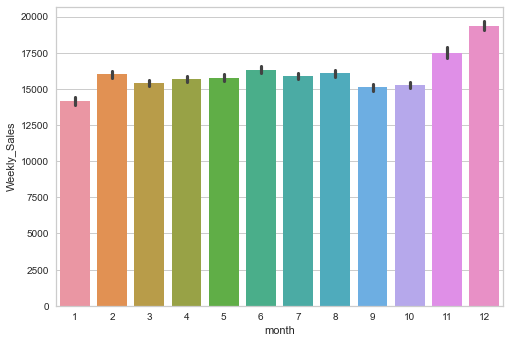

In [30]:
sns.barplot(x= df['month'], y=df['Weekly_Sales'])

In [31]:
df.sort_values('year', ascending=False)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Type,Size,Dept,Weekly_Sales,year,month,day
423324,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,NaN,NaN,2013,7,26
247869,25,2013-06-14,65.58,3.632,9439.14,890.40,269.41,3889.51,2657.01,NaN,NaN,False,B,128107,NaN,NaN,2013,6,14
247857,25,2013-03-22,28.89,3.800,5232.03,0.00,510.00,148.52,732.94,217.491942,7.439,False,B,128107,NaN,NaN,2013,3,22
247858,25,2013-03-29,34.08,3.784,8101.96,0.00,369.83,825.69,1389.48,217.575393,7.439,False,B,128107,NaN,NaN,2013,3,29
247859,25,2013-04-05,36.75,3.763,13525.91,3245.99,165.01,1109.08,1475.49,217.658844,7.191,False,B,128107,NaN,NaN,2013,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295965,31,2010-05-21,74.24,2.826,0.00,0.00,0.00,0.00,0.00,210.276844,8.200,False,A,203750,31.0,1556.50,2010,5,21
295966,31,2010-05-21,74.24,2.826,0.00,0.00,0.00,0.00,0.00,210.276844,8.200,False,A,203750,32.0,6779.62,2010,5,21
295967,31,2010-05-21,74.24,2.826,0.00,0.00,0.00,0.00,0.00,210.276844,8.200,False,A,203750,33.0,4886.16,2010,5,21
295968,31,2010-05-21,74.24,2.826,0.00,0.00,0.00,0.00,0.00,210.276844,8.200,False,A,203750,34.0,18445.32,2010,5,21


In [32]:
dfa = df.dropna(subset=['Weekly_Sales'])

In [33]:
dfa.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_x     0
Type            0
Size            0
Dept            0
Weekly_Sales    0
year            0
month           0
day             0
dtype: int64

<AxesSubplot:xlabel='year', ylabel='Weekly_Sales'>

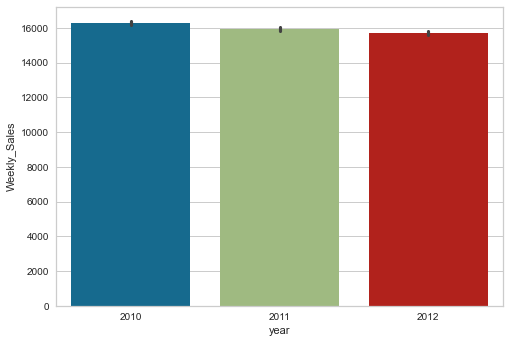

In [34]:
sns.barplot(x= dfa['year'], y=dfa['Weekly_Sales'])

In [35]:
dfa['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [36]:
dfa = pd.get_dummies(dfa)

In [37]:
dfa.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Size', 'Dept', 'Weekly_Sales', 'year', 'month', 'day',
       'Type_A', 'Type_B', 'Type_C'],
      dtype='object')

In [38]:
dfa.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,IsHoliday_x,Size,Dept,Weekly_Sales,year,month,day,Type_A,Type_B,Type_C
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,1.0,24924.50,2010,2,5,1,0,0
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,2.0,50605.27,2010,2,5,1,0,0
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,3.0,13740.12,2010,2,5,1,0,0
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,4.0,39954.04,2010,2,5,1,0,0
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,5.0,32229.38,2010,2,5,1,0,0
5,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,6.0,5749.03,2010,2,5,1,0,0
6,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,7.0,21084.08,2010,2,5,1,0,0
7,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,8.0,40129.01,2010,2,5,1,0,0
8,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,9.0,16930.99,2010,2,5,1,0,0
9,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,False,151315,10.0,30721.50,2010,2,5,1,0,0


In [39]:
dfa['Store'] = dfa['Store'].apply(str)
dfa['Dept'] = dfa['Dept'].apply(str)

In [40]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 423285
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  object        
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday_x   421570 non-null  bool          
 12  Size          421570 non-null  int64         
 13  Dept          421570 non-null  object        
 14  Weekly_Sales  421570 non-null  float64       
 15  year          421

In [41]:
dfa = pd.get_dummies(dfa)

In [42]:
dfFinal = dfa

In [43]:
# dfFinal = dfa.sample(1000)

In [44]:
# dfFinal.shape

### Arquivos de treino e teste

In [45]:
X = dfFinal.drop(columns=['Weekly_Sales','Date','year','month','day'])
y = dfFinal['Weekly_Sales']

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337256 entries, 139012 to 122426
Columns: 140 entries, Temperature to Dept_99.0
dtypes: bool(1), float64(9), int64(1), uint8(129)
memory usage: 70.1 MB


In [48]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test) 

## Modelos

### Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression
regLinear = LinearRegression().fit(X_train_std, y_train) 


In [50]:
y_predLinear = regLinear.predict(X_test_std)


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predLinear)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predLinear)))
print("R²: {}".format(r2_score(y_test,y_predLinear))) 

MAE: 8191.637251283133
RMSE: 183264544.84038535
R²: 0.6514061312934228


In [53]:
metricas = {}

In [54]:
metricas["LinearRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predLinear),
                            "RMSE":mean_squared_error(y_test,y_predLinear),
                            "R²":r2_score(y_test,y_predLinear)
} 

### SGD Regressor

In [55]:
from sklearn.linear_model import SGDRegressor

regSGD = SGDRegressor().fit(X_train_std, y_train) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [56]:
y_predSGD = regSGD.predict(X_test_std)

In [57]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predSGD)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predSGD)))
print("R²: {}".format(r2_score(y_test,y_predSGD))) 

MAE: 87686762.76261489
RMSE: 6.488278554093979e+19
R²: -123415804424.64241


In [58]:
metricas["SGDRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predSGD),
                            "RMSE":mean_squared_error(y_test,y_predSGD),
                            "R²":r2_score(y_test,y_predSGD)
} 

### Gradient Boosting Regressor

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
regGradient = GradientBoostingRegressor().fit(X_train_std, y_train) 

In [60]:
y_predGradient = regGradient.predict(X_test_std)

In [61]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predGradient)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predGradient)))
print("R²: {}".format(r2_score(y_test,y_predGradient))) 

MAE: 8076.261561398358
RMSE: 154304684.20447668
R²: 0.7064916900689469


In [62]:
metricas["GradientBoostingRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predGradient),
                            "RMSE":mean_squared_error(y_test,y_predGradient),
                            "R²":r2_score(y_test,y_predGradient)
} 

### Extra Tree Regressor

In [63]:
from sklearn.ensemble import ExtraTreesRegressor

# regExtraTree = ExtraTreesRegressor().fit(X_train_std, y_train) 
regExtraTree = ExtraTreesRegressor()

In [64]:
y_predExtraTree = regExtraTree.predict(X_test_std)

In [65]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predExtraTree)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predExtraTree)))
print("R²: {}".format(r2_score(y_test,y_predExtraTree))) 

NameError: name 'y_predExtraTree' is not defined

In [66]:
metricas["ExtraTreesRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predExtraTree),
                            "RMSE":mean_squared_error(y_test,y_predExtraTree),
                            "R²":r2_score(y_test,y_predExtraTree)
} 

NameError: name 'y_predExtraTree' is not defined

In [67]:
from skopt import BayesSearchCV

In [68]:
params_grid = {
    "n_estimators":[100, 150, 200],
    "criterion":["mse", "mae"],
    "max_depth":[None, 2, 4, 5],
    "min_samples_split":[2, 3, 4],
    "max_features":['auto', 'sqrt', 'log2'],
    'min_samples_leaf':[1, 2, 3],
    "bootstrap":[False, True],
    'min_weight_fraction_leaf':[0.0, 0.1, 0.2]
} 

In [69]:
bayes_search = BayesSearchCV(regExtraTree, search_spaces=params_grid, n_jobs=-1,verbose=2)
bayes_search.fit(X_train_std, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
bayes_best = bayes_search.best_estimator_

In [ ]:
bayes_best

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=4, min_weight_fraction_leaf=0.0,
                    n_estimators=150, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
y_predExtraTreeBayes = bayes_best.predict(X_test)

MAE: 16541.689135888886
RMSE: 521229962.45900965
R²: 0.08836052016468621

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regRandomForest = RandomForestRegressor().fit(X_train_std, y_train) 


In [ ]:
y_predRandomForest = regRandomForest.predict(X_test_std)

In [ ]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predRandomForest)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predRandomForest)))
print("R²: {}".format(r2_score(y_test,y_predRandomForest))) 

MAE: 6997.627775000004
RMSE: 204353817.8980566
R²: 0.642581927999591


In [ ]:
metricas["RandomForestRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predRandomForest),
                            "RMSE":mean_squared_error(y_test,y_predRandomForest),
                            "R²":r2_score(y_test,y_predRandomForest)
} 

### Huber Regressor

In [ ]:
from sklearn.linear_model import HuberRegressor

regHuber = HuberRegressor().fit(X_train_std, y_train) 

In [ ]:
y_predHuber = regHuber.predict(X_test_std)

In [ ]:
print("MAE: {}".format(mean_absolute_error(y_test,y_predHuber)))
print("RMSE: {}".format(mean_squared_error(y_test,y_predHuber)))
print("R²: {}".format(r2_score(y_test,y_predHuber))) 

MAE: 7434.02247819663
RMSE: 215314573.0950271
R²: 0.6234113931377272


In [ ]:
metricas["HuberRegressor"]={
                            "MAE":mean_absolute_error(y_test,y_predHuber),
                            "RMSE":mean_squared_error(y_test,y_predHuber),
                            "R²":r2_score(y_test,y_predHuber)
} 

In [ ]:
resumo = pd.DataFrame.from_dict(metricas, orient='index') 

In [ ]:
resumo

#MAE: ExtraTreesRegressor
#RMSE: ExtraTreesRegressor
#R²: ExtraTreesRegressor

,MAE,RMSE,R²
LinearRegressor,8900.949715,2.317575e+08,0.594652
SGDRegressor,8682.226676,2.274610e+08,0.602167
GradientBoostingRegressor,8953.380049,2.330669e+08,0.592362
ExtraTreesRegressor,6137.141101,1.819194e+08,0.681820
RandomForestRegressor,6997.627775,2.043538e+08,0.642582
HuberRegressor,7434.022478,2.153146e+08,0.623411
